# Transfer Learning Using Pretrained Models in Tensorflow Hub.

- We will reuse weights Pretrained *Convolutional Neural Network* trained on the popular ImageNet Dataset. 

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow_datasets as tfds

## Dataset

- Let's use the popular and simple flowers dataset for image classification using Pretrained Model.

In [ ]:
dataset, info = tfds.load(
                            'tf_flowers',
                            with_info=True,
                            as_supervised=True,
)


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

### Number of classes of flowers in dataset

In [ ]:
classes = info.features["label"].names
print("Classes of flowers : ", classes)

Classes of flowers :  ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [ ]:
num_classes = info.features["label"].num_classes
print("Numer of classes : ", num_classes)

Numer of classes :  5


### Number of instances

In [ ]:
dataset_size = info.splits["train"].num_examples

print("Number of images in datatset : ", dataset_size)

Number of images in datatset :  3670


### Splitting the train, test sets

In [ ]:
train_set, test_set, valid_set = tfds.load(
                                                "tf_flowers",
                                                as_supervised = True,
                                                split = ["train[:75%]", "train[75%:85%]", "train[85%:]"]
)

### Image samples

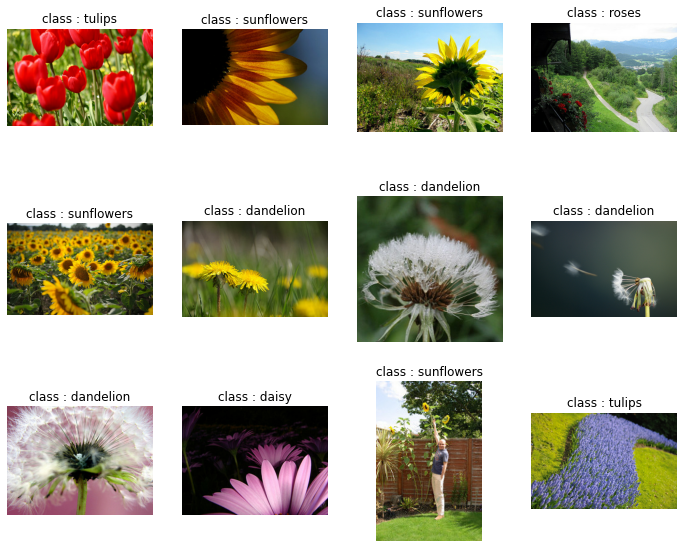

In [ ]:
plt.figure(figsize=(12, 10))
index = 0

for image, label in train_set.take(12):
    index+=1
    plt.subplot(3, 4, index)
    plt.imshow(image)
    plt.title(f"class : {classes[label]}")
    plt.axis("off")

plt.show()

## We are going to use Popular Xception Model to train our dataset.
- It takes input images of size (224x224x3), so we will have to resize all input images to that rsolution.

In [ ]:
def resize_image(image, label):
    Image = tf.image.resize(image, [224, 224])
    Image = keras.applications.xception.preprocess_input(Image)
    return Image,label


#### Let’s apply this preprocessing function to all 3 datasets, and let’s also shuffle & repeat the training set, and add batching & prefetching to all datasets:

In [ ]:
batch_size = 32
train_set = train_set.shuffle(1000).repeat()
train_set = train_set.map(resize_image).batch(batch_size).prefetch(1)
valid_set = valid_set.map(resize_image).batch(batch_size).prefetch(1)
test_set = test_set.map(resize_image).batch(batch_size).prefetch(1)

In [ ]:
print("resized train set : ", train_set)
print("resized test set : ",  test_set)
print("resized validation set : ", valid_set)

resized train set :  <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
resized test set :  <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
resized validation set :  <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>


### Importing the Xception model 
- Here, we will not import top layer of the xception model because Xception model was trained to classify thousands of classes on ImageNet dataset which had 14,197,122 images organized into 21,841 classes.

In [ ]:
from keras.applications.xception import Xception

In [ ]:
xception_model = Xception(include_top = False,
                      weights = 'imagenet',
                      input_shape = (224, 224, 3)
)

## Preserving the Weights
index = 0
for layer in xception_model.layers:
    layer.trainable = False
    print(index, layer.name)
    index += 1

83697664/83683744 [==============================] - 1s 0us/step
0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_ac

### Creating our classifier on top of the pretrained model

In [ ]:
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

## Flattening the output of xception model
flatten = GlobalAveragePooling2D()(xception_model.output)

## Creating top layer with output neurons as number of classes
top_layer = Dense(num_classes, activation = 'softmax')(flatten)

classifier = Model(inputs = xception_model.input, outputs = top_layer)

### Model

In [ ]:
## Model Summary
classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

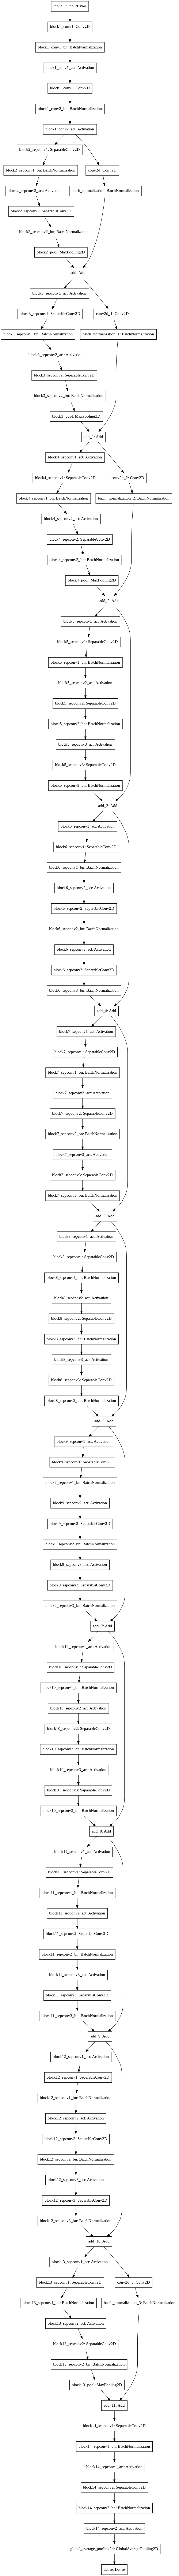

In [ ]:
# model graph

from tensorflow.keras.utils import plot_model
plot_model(classifier)

### Cmpiling the model

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=0.01)

classifier.compile(optimizer = optimizer, 
                   loss = "sparse_categorical_crossentropy",
                   metrics=["accuracy"]
                   
)

### Training the model

In [ ]:
batch_size = 32

history = classifier.fit(train_set,
                         steps_per_epoch=int(0.75 * dataset_size / batch_size),
                        validation_data=valid_set,
                        validation_steps=int(0.15 * dataset_size / batch_size),
                        epochs=5
)

Epoch 1/5
86/86 [==============================] - 67s 365ms/step - loss: 0.6637 - accuracy: 0.8143 - val_loss: 0.3341 - val_accuracy: 0.8824
Epoch 2/5
86/86 [==============================] - 31s 356ms/step - loss: 0.2601 - accuracy: 0.9132 - val_loss: 0.2848 - val_accuracy: 0.8952
Epoch 3/5
86/86 [==============================] - 31s 359ms/step - loss: 0.1480 - accuracy: 0.9506 - val_loss: 0.2722 - val_accuracy: 0.9044
Epoch 4/5
86/86 [==============================] - 31s 359ms/step - loss: 0.1142 - accuracy: 0.9633 - val_loss: 0.2722 - val_accuracy: 0.9044
Epoch 5/5
86/86 [==============================] - 31s 360ms/step - loss: 0.0976 - accuracy: 0.9724 - val_loss: 0.2641 - val_accuracy: 0.9007


### Model Evaluation

(0.0, 1.0)

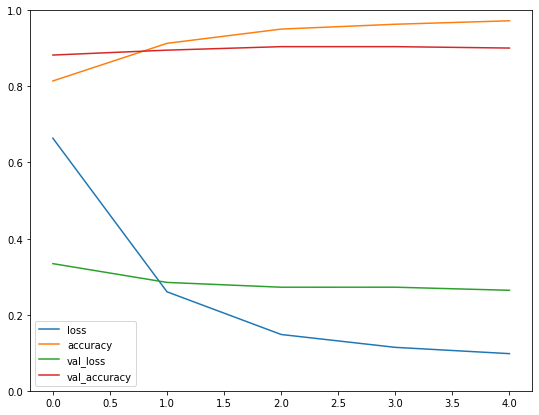

In [ ]:
import pandas as pd
hist = pd.DataFrame(history.history).plot(figsize=(9, 7))
hist.set_ylim(0, 1)

## Let's Create Another model with all layers as trainable layers

In [ ]:
for layer in xception_model.layers:
    layer.trainable = True

## Compiling The new model

optimizer = keras.optimizers.SGD(learning_rate=0.01, 
                                 momentum=0.9,
                                 nesterov=True, decay=0.001)

classifier.compile(optimizer = optimizer, 
                   loss = "sparse_categorical_crossentropy",
                   metrics=["accuracy"]
                   
)


## Trianing the model

batch_size = 32

history2 = classifier.fit(train_set,
                         steps_per_epoch=int(0.75 * dataset_size / batch_size),
                        validation_data=valid_set,
                        validation_steps=int(0.15 * dataset_size / batch_size),
                        epochs=15
)

Epoch 1/15
86/86 [==============================] - 120s 1s/step - loss: 0.3048 - accuracy: 0.8877 - val_loss: 0.3355 - val_accuracy: 0.9081
Epoch 2/15
86/86 [==============================] - 111s 1s/step - loss: 0.0516 - accuracy: 0.9844 - val_loss: 0.2030 - val_accuracy: 0.9320
Epoch 3/15
86/86 [==============================] - 111s 1s/step - loss: 0.0135 - accuracy: 0.9978 - val_loss: 0.1777 - val_accuracy: 0.9393
Epoch 4/15
86/86 [==============================] - 111s 1s/step - loss: 0.0117 - accuracy: 0.9967 - val_loss: 0.1997 - val_accuracy: 0.9357
Epoch 5/15
86/86 [==============================] - 111s 1s/step - loss: 0.0083 - accuracy: 0.9975 - val_loss: 0.1865 - val_accuracy: 0.9430
Epoch 6/15
86/86 [==============================] - 111s 1s/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 0.1876 - val_accuracy: 0.9485
Epoch 7/15
86/86 [==============================] - 111s 1s/step - loss: 0.0047 - accuracy: 0.9982 - val_loss: 0.1905 - val_accuracy: 0.9393
Epoch 8/15
86

(0.0, 1.0)

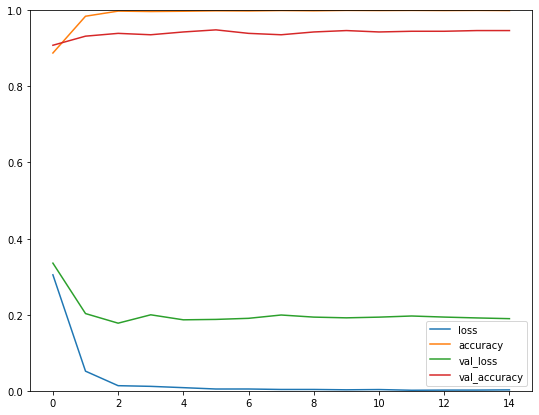

In [ ]:
import pandas as pd
hist = pd.DataFrame(history2.history).plot(figsize=(9, 7))
hist.set_ylim(0, 1)

## We can use this model further to make predictions.